In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import control as ct
from scipy.optimize import differential_evolution
sns.set_style('whitegrid')

In [3]:
df = pd.read_csv('saida.txt', sep=' ', decimal=',').iloc[:, [2, 5, 6]]
df.columns = ['time', 'temperature', 'lamp']
df.index = list(map(pd.Timestamp, df.pop('time').values))
df.head()

,temperature,lamp
2019-04-25 15:30:31,25.289351,0
2019-04-25 15:30:32,25.289351,0
2019-04-25 15:30:33,25.318287,0
2019-04-25 15:30:34,25.318287,0
2019-04-25 15:30:35,25.318287,0


Text(0.5, 0, 'Tempo')

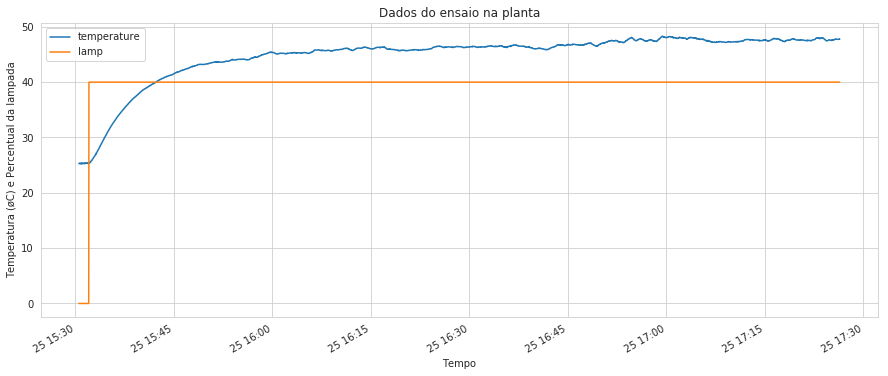

In [8]:
df.plot(figsize=(15,6));
plt.title('Dados do ensaio na planta');
plt.ylabel('Temperatura (øC) e Percentual da lampada')
plt.xlabel('Tempo')

In [4]:
offset = df['temperature'][0]
df['temperature_no_offset'] = df['temperature'] - offset
final_value = df['temperature'][-15*60:].mean()
step_init = df['lamp'][0]
step_final = df['lamp'][-1]
gain = (final_value - offset) /step_final

def first_order(tau, gain, delay=20):
    s = ct.tf([1, 0],[0, 1])
    return (gain / (tau*s + 1)) * ct.tf(*ct.pade(delay, n=1))

def second_order(Wn, zeta, gain, delay=20):
    s = ct.tf([1, 0],[0, 1])
    return (gain*Wn**2  / (s**2 + 2*Wn*zeta*s + Wn**2)) * ct.tf(*ct.pade(delay, n=1))

def MSE(signal, simulated_signal):
    return np.mean(np.sqrt(np.square(simulated_signal-signal)))

## Sistema de primeira ordem

In [5]:
def objective(tau):
    sys  = first_order(tau, gain, delay=0)[0]
    simulated = ct.forced_response(
        sys,
        T=range(len(df.index)),
        U=df['lamp'].values - step_init
    )[1]
    return MSE(df['temperature_no_offset'], simulated)

differential_evolution(objective, [(0, 1000)])

     fun: 0.7450965662006235
     jac: array([0.00013953])
 message: 'Optimization terminated successfully.'
    nfev: 86
     nit: 3
 success: True
       x: array([670.43244859])

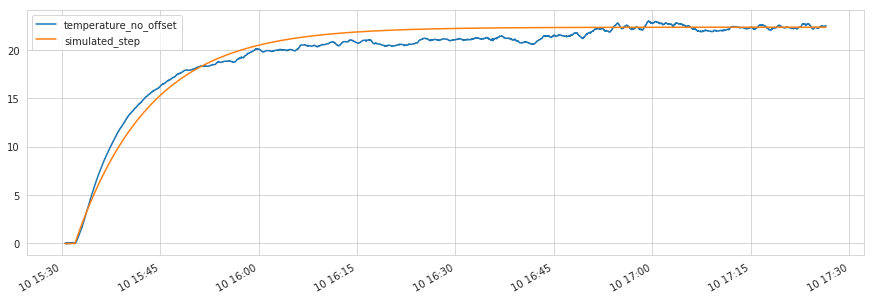

In [6]:
df['simulated_step'] = ct.forced_response(
    first_order(676, gain, delay=0),
    T=range(len(df.index)),
    U=df['lamp'].values - step_inita
)[1]
df[['temperature_no_offset', 'simulated_step']].plot(figsize=(15,5));

## Observações

A simulação com sistemas de primeira ordem atingiu desempenho satisfatório ao aproximar a resposta do sistema. A aproximação no inicio da resposta foi muito boa, porém após o primeiro tau do sistema, temos um distanciamento. Essa diferença poderia ser modelada utilizando um sistema de segunda ordem.

## Sistema de segunda ordem

In [7]:
time = range(len(df.index))
input_signal = df['lamp'].values - step_init

In [54]:
def objective(args):
    sys  = second_order(args[0], args[1], gain)
    simulated = ct.forced_response(
        sys,
        T=time,
        U=input_signal
    )[1]
    return MSE(df['temperature_no_ofsset'], simulated)

a = differential_evolution(objective, [(0.0001, 1), (0, 20)], workers=4)
a

     fun: 0.7781517522604161
     jac: array([ 0.01463138, -0.00034153])
 message: 'Optimization terminated successfully.'
    nfev: 474
     nit: 13
 success: True
       x: array([ 0.05029719, 16.38716099])

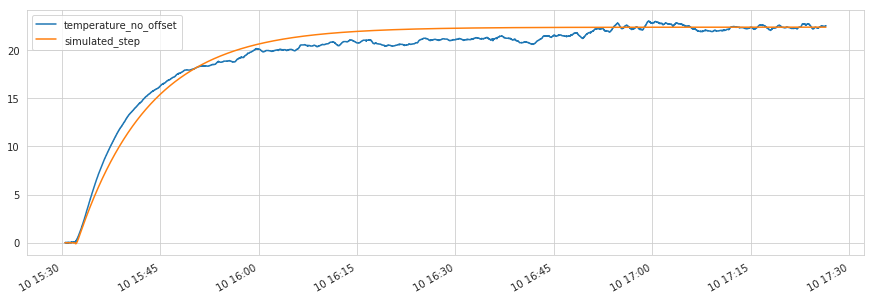

In [8]:
a = {'x': [ 0.05029719, 16.38716099]}

sys  = second_order(a['x'][0], a['x'][1], gain)
df['simulated_step'] = ct.forced_response(
    sys,
    T=time,
    U=input_signal
)[1]

df[['temperature_no_offset', 'simulated_step']].plot(figsize=(15,5));

## Observações
O sistema de segunda ordem não conseguiu aproximar melhor a resposta do que o sistema de primeira ordem, portanto, o sistema de primeira ordem será utilizado para o projeto de controle. 

## Projeto do PID

In [9]:
def PID(Kc, Ti, Td):
    s = ct.tf([1, 0],[0, 1])
    return Kc*(1 + 1/(Ti*s) + Td*s)


def simulate(system, controler):
    return ct.forced_response(
        ct.feedback(system*controler),
        T=time,
        U=input_signal
    )[1]

def objective(args):
    pid = PID(args[0], args[1], args[2])
    result = simulate(sys, pid)
    return MSE(input_signal, result)

In [105]:
b = differential_evolution(objective, [(30, 35), (170, 180), (25, 35)], workers=4)
b

     fun: 0.2611670171625632
     jac: array([-5.76715897e-03, -1.05471187e-06,  2.72171174e-04])
 message: 'Optimization terminated successfully.'
    nfev: 604
     nit: 7
 success: True
       x: array([ 35.        , 173.18718823,  26.93740158])

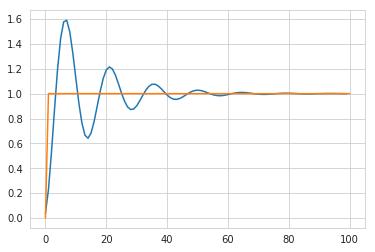

In [23]:
simu = ct.step_response(ct.feedback(sys * PID(*tuple(b['x']))))
plt.plot(simu[1])
step = [0]
step.extend(np.ones(len(simu[1])))
plt.plot(step)
# df[['temperature_no_ofsset', 'simulated_step']].plot(figsize=(15,5));

In [22]:
sys = first_order(676, gain, delay=0)
b = differential_evolution(objective, [(1, 10), (1, 50), (1, 5)], workers=4)
b

     fun: 0.7512358506547807
     jac: array([-6.35158148e-02,  3.95083966e-04, -1.53765889e-05])
 message: 'Optimization terminated successfully.'
    nfev: 710
     nit: 9
 success: True
       x: array([10.        ,  9.33277871,  4.61427155])

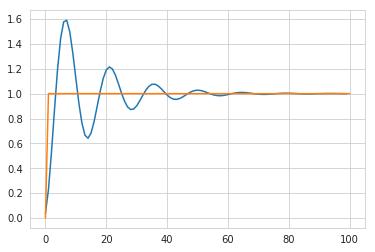

In [24]:
simu = ct.step_response(ct.feedback(sys * PID(*tuple(b['x']))))
plt.plot(simu[1])
step = [0]
step.extend(np.ones(len(simu[1])))
plt.plot(step)

In [33]:
df.index[0].second

49

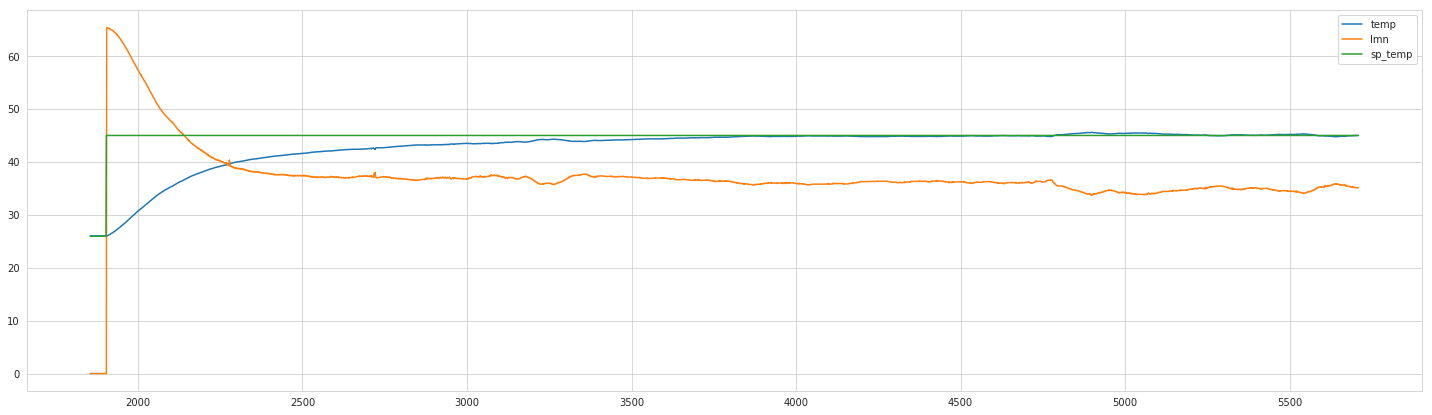

In [53]:
df = pd.read_csv('exit.txt', sep=' ', decimal=',').iloc[:,[2, 5, 6, 7, 8]]
df.columns = ['time', 'temp', 'lmn','sp_temp', 'man_on']
# df.index = list(map(pd.Timestamp, df.pop('time').values))
# df['time'] = [x.second for x in df.index]

data = df.loc[1855:]
data.plot(figsize=(25, 7))

In [55]:
data.pop('time')

1855    16:42:45
1856    16:42:46
1857    16:42:47
1858    16:42:48
1859    16:42:49
1860    16:42:50
1861    16:42:51
1862    16:42:52
1863    16:42:53
1864    16:42:54
1865    16:42:55
1866    16:42:56
1867    16:42:57
1868    16:42:58
1869    16:42:59
1870    16:43:00
1871    16:43:01
1872    16:43:02
1873    16:43:03
1874    16:43:04
1875    16:43:05
1876    16:43:06
1877    16:43:07
1878    16:43:08
1879    16:43:09
1880    16:43:10
1881    16:43:11
1882    16:43:12
1883    16:43:13
1884    16:43:14
          ...   
5680    17:46:30
5681    17:46:31
5682    17:46:32
5683    17:46:33
5684    17:46:34
5685    17:46:35
5686    17:46:36
5687    17:46:37
5688    17:46:38
5689    17:46:39
5690    17:46:40
5691    17:46:41
5692    17:46:42
5693    17:46:43
5694    17:46:44
5695    17:46:45
5696    17:46:46
5697    17:46:47
5698    17:46:48
5699    17:46:49
5700    17:46:50
5701    17:46:51
5702    17:46:52
5703    17:46:53
5704    17:46:54
5705    17:46:55
5706    17:46:56
5707    17:46:

In [57]:
data['man_on'] = list(map(int, data['man_on'].values))
csv = data.to_csv(index=False)

f = open('exit_tratada.csv', "w")
f.write(csv)
f.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
